Imports

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

# segon comentari!

Read Data

In [112]:
raw_songs = pd.read_csv('taylor_swift_spotify.csv')

assert (raw_songs.index == raw_songs['Unnamed: 0']).all()
songs = raw_songs.drop(columns=['Unnamed: 0', 'id', 'uri'])

Initial plot

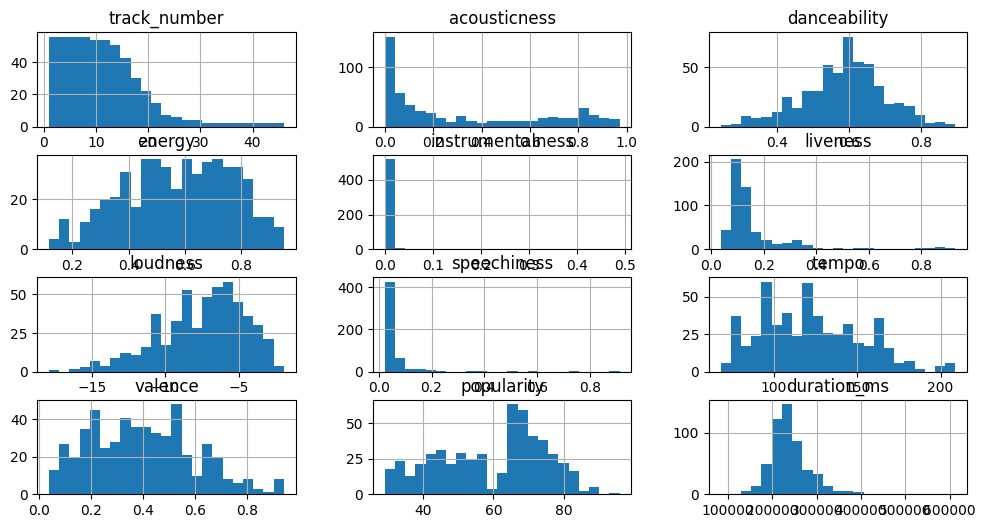

In [113]:
songs.hist(bins=23)
plt.show()

Converting Release date to Datetime / int

In [114]:
songs['release_date'] = pd.to_datetime(songs['release_date'])
songs['release_date'] = (songs['release_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D') # days since the 1970-01-01

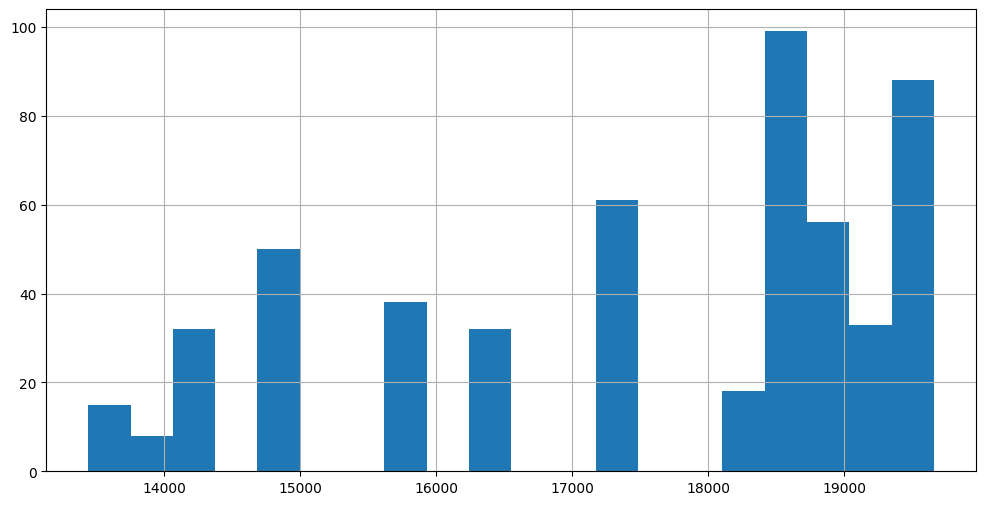

In [115]:
songs['release_date'].hist(bins=20)
plt.show()

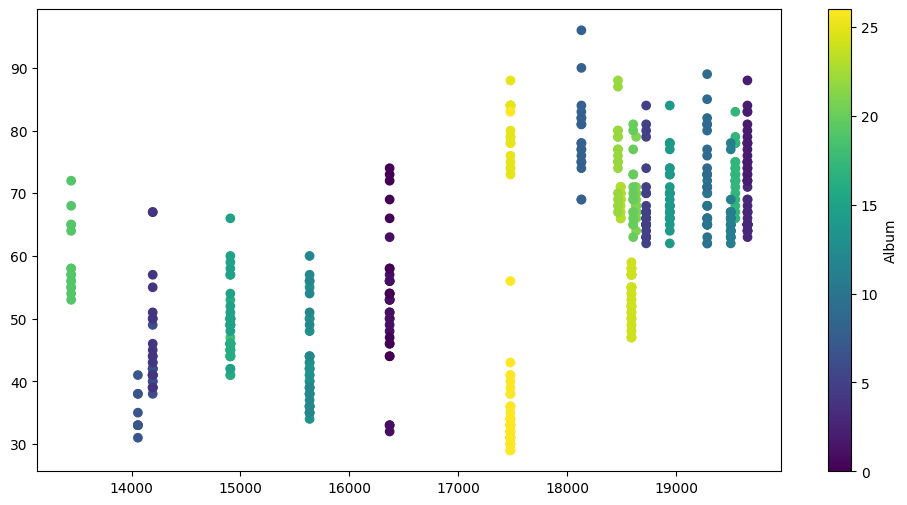

In [116]:
plt.scatter(songs['release_date'], songs['popularity'], c=songs['album'].astype('category').cat.codes)
plt.colorbar(label='Album')
plt.show()

Add categorical variables

performed_live categorical variable

In [117]:
# "folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]"
live_albums = ["Live From Clear Channel Stripped 2008", "Speak Now World Tour Live", "reputation Stadium Tour Surprise Song Playlist"]
songs['performed_live'] = songs['album'].isin(live_albums)

songs['performed_live'].value_counts()

performed_live
False    460
True      70
Name: count, dtype: int64

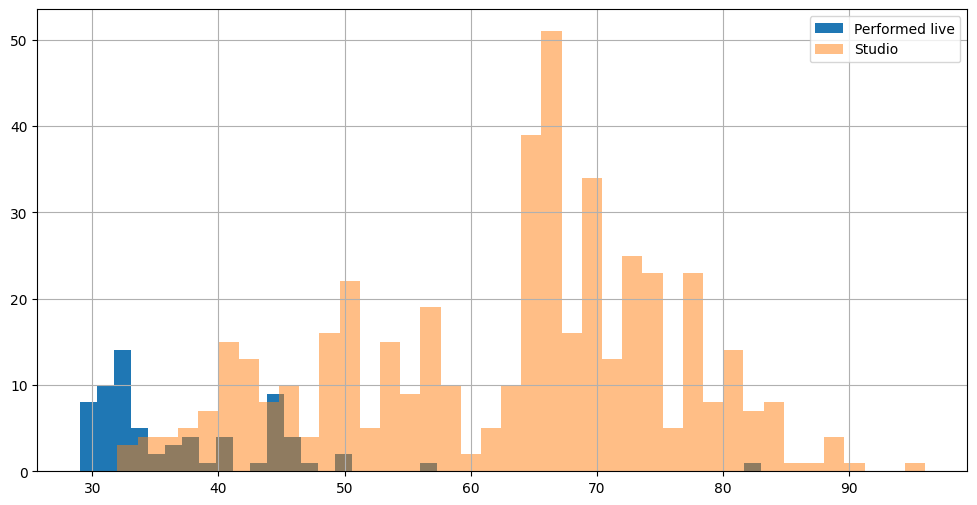

In [118]:
songs[songs['performed_live'] == True ]['popularity'].hist(bins=40, alpha=1)
songs[songs['performed_live'] == False]['popularity'].hist(bins=40, alpha=0.5)
plt.legend(['Performed live', 'Studio'])
plt.show()


Convert Taylor’s Version to Taylor's Version

In [119]:
# songs['name'] = songs['name'].str.replace("Taylor’s Version", "Taylor's Version")
# songs['taylors_version'] = songs['name'].str.contains("Taylor's Version")
songs['taylors_version'] = songs['name'].str.contains('|'.join(['Taylor\'s Version', 'Taylor’s Version']))
songs['taylors_version'].value_counts()

taylors_version
False    409
True     121
Name: count, dtype: int64

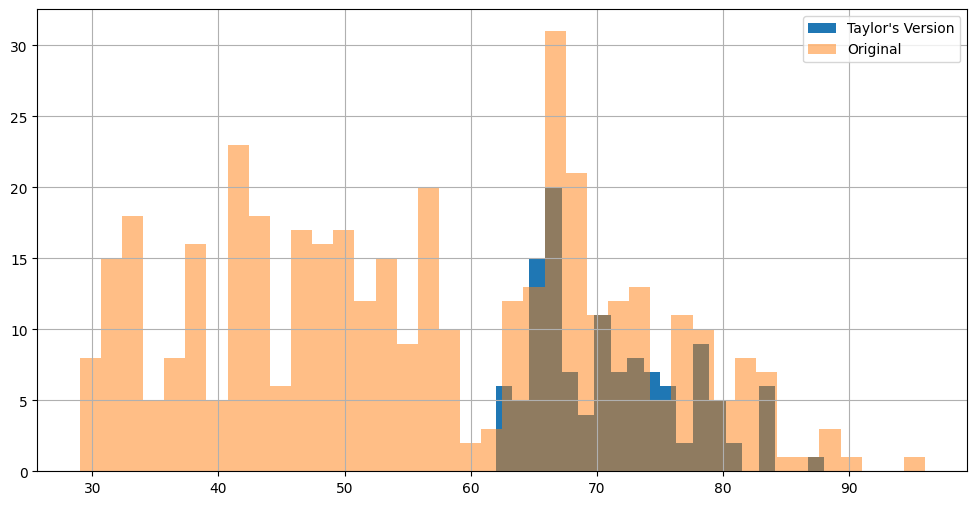

In [120]:
songs[songs['taylors_version'] == True ]['popularity'].hist(bins=20, alpha=1)
songs[songs['taylors_version'] == False]['popularity'].hist(bins=40, alpha=0.5)
plt.legend(['Taylor\'s Version', 'Original'])
plt.show()

Track Number

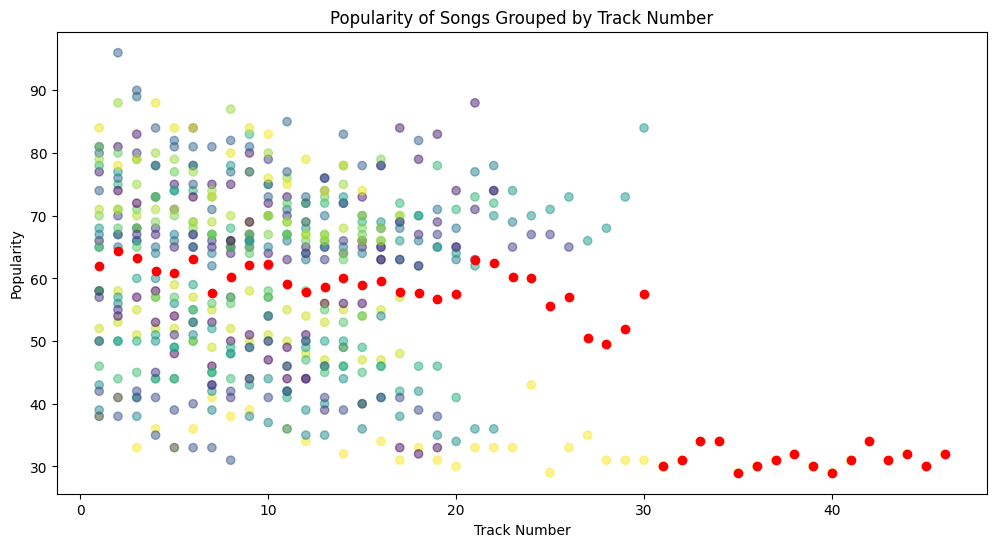

In [121]:
plt.scatter(songs['track_number'], songs['popularity'], c=songs['album'].astype('category').cat.codes, alpha=0.5)

grouped_songs = songs.groupby('track_number')['popularity'].mean()

plt.scatter(grouped_songs.index, grouped_songs.values, c='red')
plt.xlabel('Track Number')
plt.ylabel('Popularity')
plt.title('Popularity of Songs Grouped by Track Number')
plt.show()

Deluxe edition

In [122]:
deluxe_wordings = ['deluxe', 'platinum']
songs[songs['album'].str.contains('|'.join(deluxe_wordings), case=False)]
songs['deluxe_album'] = songs['album'].str.contains('|'.join(deluxe_wordings), case=False)

songs['deluxe_album'].value_counts()

deluxe_album
False    360
True     170
Name: count, dtype: int64

<Axes: >

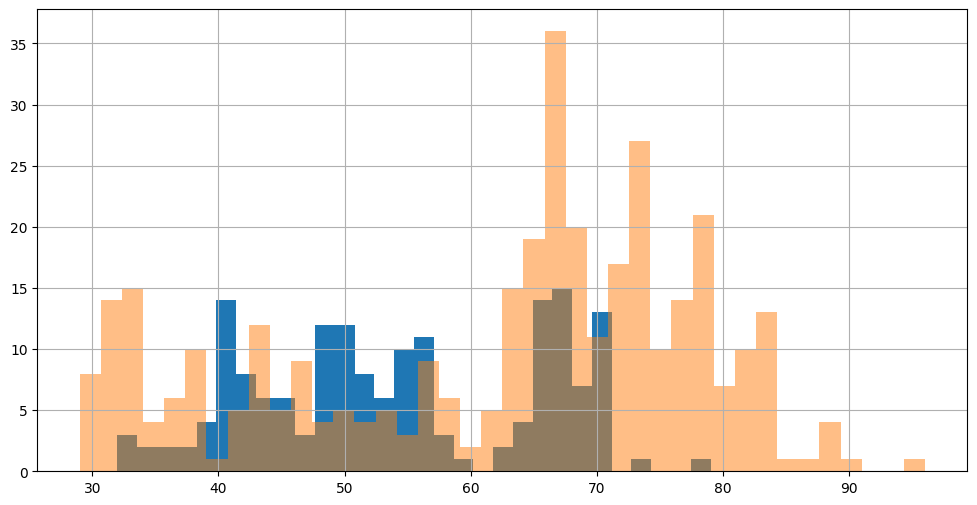

In [123]:
songs[songs['deluxe_album'] == True ]['popularity'].hist(bins=30, alpha=1)
songs[songs['deluxe_album'] == False]['popularity'].hist(bins=40, alpha=0.5)



In [124]:
deluxe_wordings = ['\\[Deluxe\\]', '\\[deluxe edition\\]', '(Deluxe Edition)', '(deluxe version)', 'Platinum Edition']

songs[songs['album'].str.contains('|'.join(['deluxe', 'platinum']), case=False)]

,name,album,release_date,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms,performed_live,taylors_version,deluxe_album
0,Welcome To New York (Taylor's Version),1989 (Taylor's Version) [Deluxe],19657,1,0.009420,0.757,0.610,0.000037,0.3670,-4.840,0.0327,116.998,0.685,66,212600,False,True,True
1,Blank Space (Taylor's Version),1989 (Taylor's Version) [Deluxe],19657,2,0.088500,0.733,0.733,0.000000,0.1680,-5.376,0.0670,96.057,0.701,67,231833,False,True,True
2,Style (Taylor's Version),1989 (Taylor's Version) [Deluxe],19657,3,0.000421,0.511,0.822,0.019700,0.0899,-4.785,0.0397,94.868,0.305,68,231000,False,True,True
3,Out Of The Woods (Taylor's Version),1989 (Taylor's Version) [Deluxe],19657,4,0.000537,0.545,0.885,0.000056,0.3850,-5.968,0.0447,92.021,0.206,67,235800,False,True,True
4,All You Had To Do Was Stay (Taylor's Version),1989 (Taylor's Version) [Deluxe],19657,5,0.000656,0.588,0.721,0.000000,0.1310,-5.579,0.0317,96.997,0.520,65,193289,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,You're Not Sorry,Fearless Platinum Edition,14194,15,0.130000,0.459,0.459,0.000002,0.1130,-4.126,0.0275,134.018,0.281,40,261800,False,False,True
490,The Way I Loved You,Fearless Platinum Edition,14194,16,0.032200,0.436,0.712,0.000000,0.1110,-3.689,0.0329,160.886,0.379,41,244240,False,False,True
491,Forever & Always,Fearless Platinum Edition,14194,17,0.090700,0.605,0.829,0.000000,0.1060,-4.993,0.0549,128.012,0.514,41,225333,False,False,True
492,The Best Day,Fearless Platinum Edition,14194,18,0.611000,0.664,0.447,0.000001,0.1390,-8.535,0.0292,126.079,0.364,39,245346,False,False,True


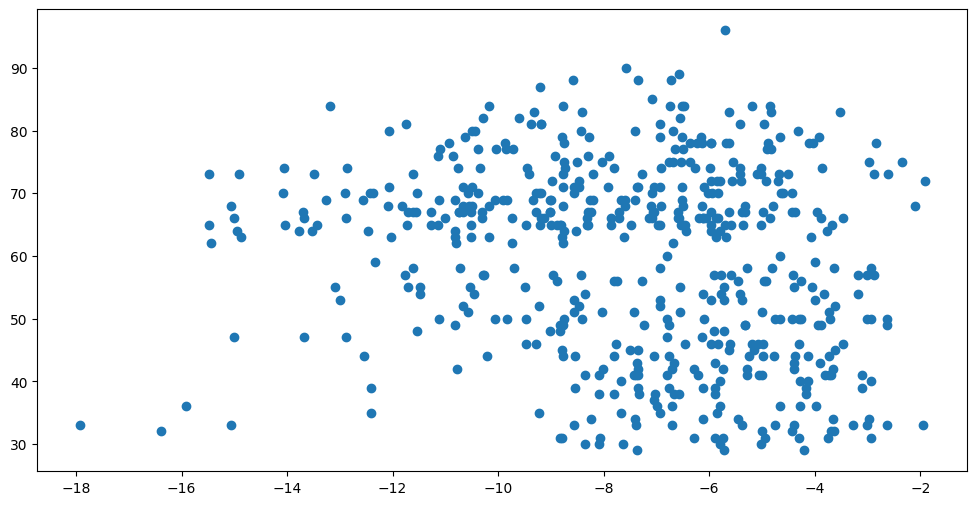

In [125]:
plt.scatter(songs['loudness'], songs['popularity'],)


<Axes: >

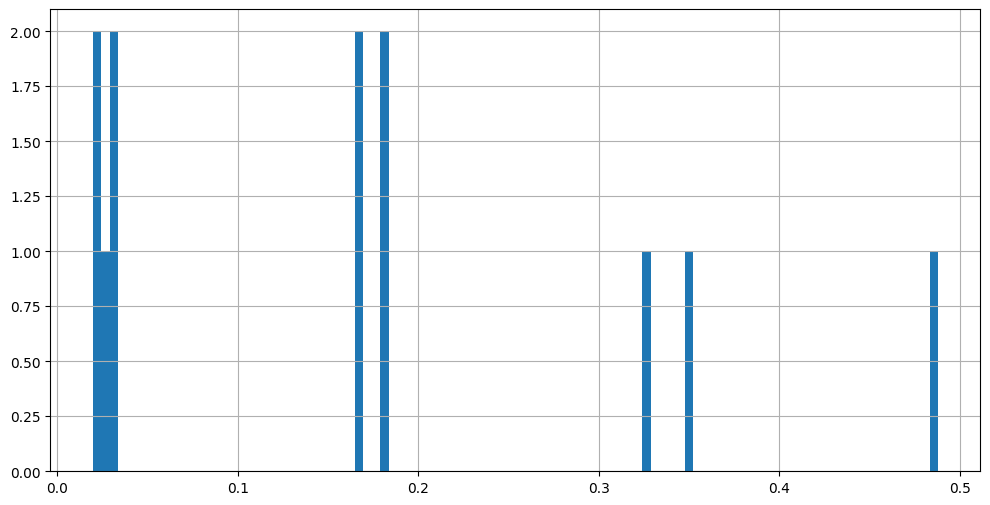

In [126]:
songs[songs['instrumentalness'] > 0.01]['instrumentalness'].hist(bins=100)

In [127]:
len(songs[songs['instrumentalness'] > 0.01]['instrumentalness'])

12

In [128]:
songs[songs['instrumentalness'] > 0.1]

,name,album,release_date,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms,performed_live,taylors_version,deluxe_album
74,Labyrinth,Midnights (The Til Dawn Edition),19503,10,0.804,0.493,0.308,0.328,0.1230,-15.489,0.0436,109.993,0.130,65,247962,False,False,False
97,Labyrinth,Midnights (3am Edition),19287,10,0.791,0.487,0.313,0.348,0.1240,-15.434,0.0487,110.039,0.141,62,247962,False,False,False
117,Labyrinth,Midnights,19286,10,0.785,0.406,0.306,0.488,0.1220,-15.480,0.0517,110.014,0.122,73,247962,False,False,False
179,gold rush,evermore (deluxe version),18634,3,0.830,0.512,0.462,0.166,0.1210,-10.491,0.0408,112.050,0.353,68,185320,False,False,True
188,long story short,evermore (deluxe version),18634,12,0.660,0.546,0.730,0.179,0.0972,-7.704,0.0417,157.895,0.573,67,215920,False,False,True
196,gold rush,evermore,18607,3,0.830,0.512,0.462,0.166,0.1210,-10.491,0.0408,112.050,0.353,71,185320,False,False,False
205,long story short,evermore,18607,12,0.660,0.546,0.730,0.179,0.0972,-7.704,0.0417,157.895,0.573,66,215920,False,False,False


In [129]:
print(len(songs[songs['album'] == 'Midnights']))

print(len(songs[songs['album'] == 'Midnights (3am Edition)']))

print(len(songs[songs['album'] == 'Midnights (The Til Dawn Edition)']))

13
20
23


In [130]:
len(songs[songs['name'] == 'Anti-Hero'])

3

In [131]:
# print the dataset sorted by release date


### Popularity vs time:

Popularity vs time

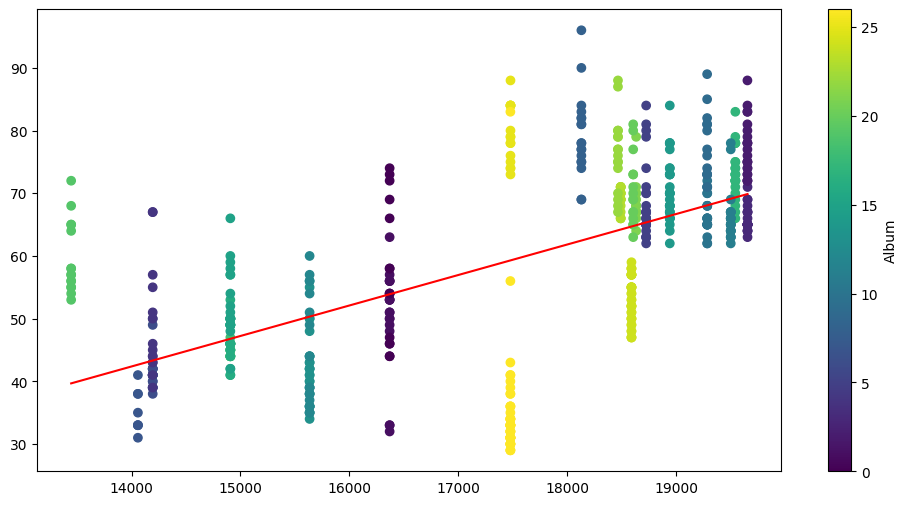

0.0048619186345503695 -25.695051326908715


In [132]:
import numpy as np
import matplotlib.pyplot as plt


songs_without_live = songs[songs['performed_live'] == False]

# Scatter plot
plt.scatter(songs['release_date'], songs['popularity'], c=songs['album'].astype('category').cat.codes)
plt.colorbar(label='Album')

# Linear regression line
x = songs['release_date']
y = songs['popularity']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')

plt.show()
print(m, b)

Popularity vs time withou live performances

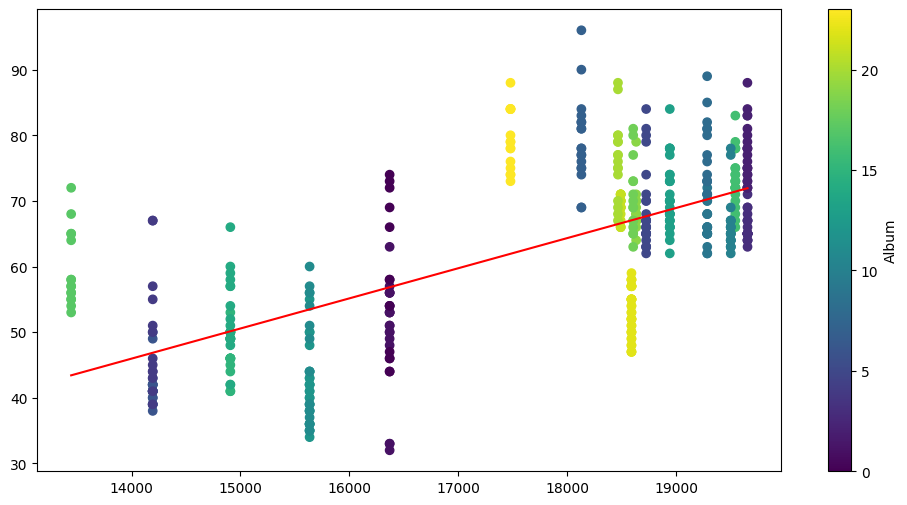

0.0045901002388595395 -18.29342269050136


In [133]:
import numpy as np
import matplotlib.pyplot as plt


songs_without_live = songs[songs['performed_live'] == False]

# Scatter plot
plt.scatter(songs_without_live['release_date'], songs_without_live['popularity'], c=songs_without_live['album'].astype('category').cat.codes)
plt.colorbar(label='Album')

# Linear regression line
x = songs_without_live['release_date']
y = songs_without_live['popularity']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')

plt.show()
print(m, b)

Difference from regression line in popularity vs time 

ValueError: 'c' argument has 530 elements, which is inconsistent with 'x' and 'y' with size 460.

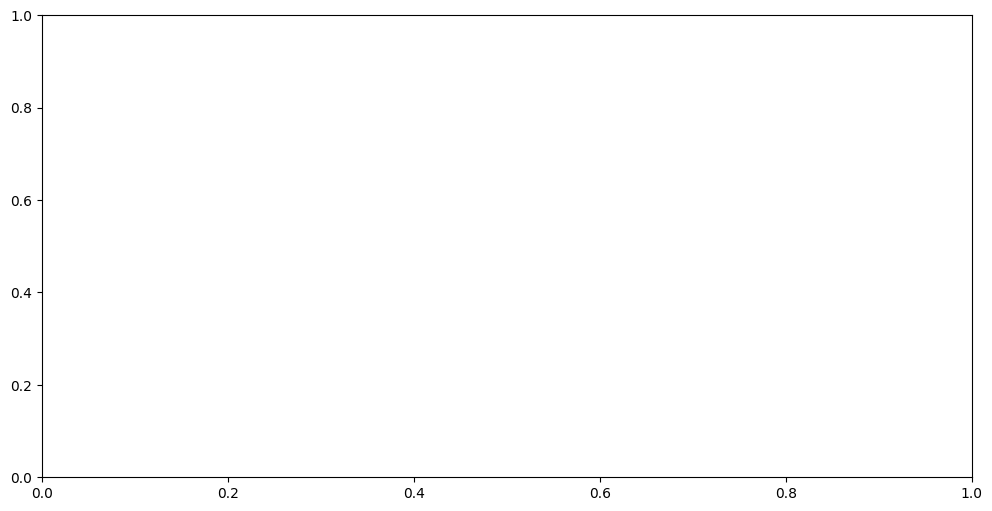

In [134]:
# Scatter plot
plt.scatter(x, y - (m*x + b), c=songs['album'].astype('category').cat.codes)
plt.colorbar(label='Album')

plt.xlabel('Release Date')
plt.ylabel('Difference from Regression Line')
plt.title('Difference between Popularity and Regression Line')
plt.show()


### Popularity vs mean by album

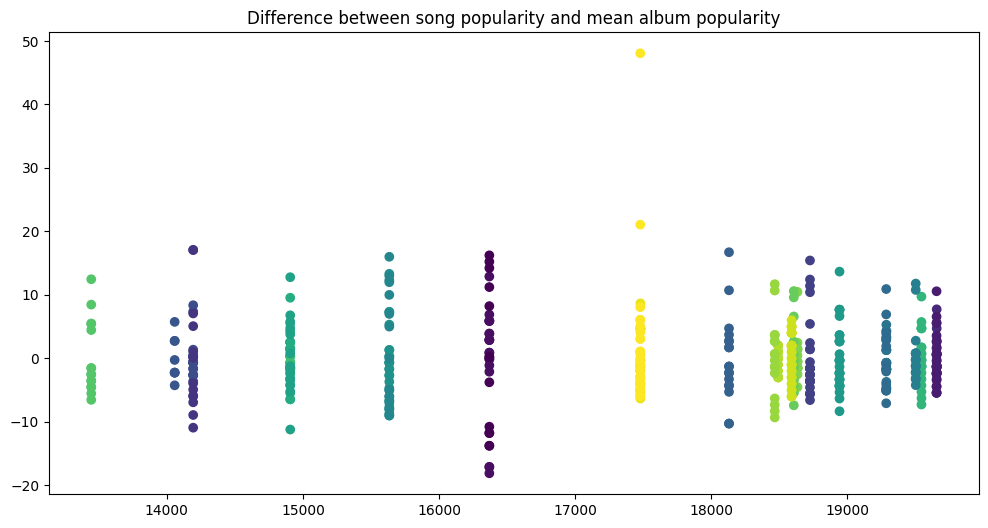

In [ ]:
albums = songs.groupby('album')['popularity'].mean()

plt.scatter(songs['release_date'], songs['popularity'] - albums[songs['album']].values, c=songs['album'].astype('category').cat.codes)
plt.title("Difference between song popularity and mean album popularity")
plt.show()

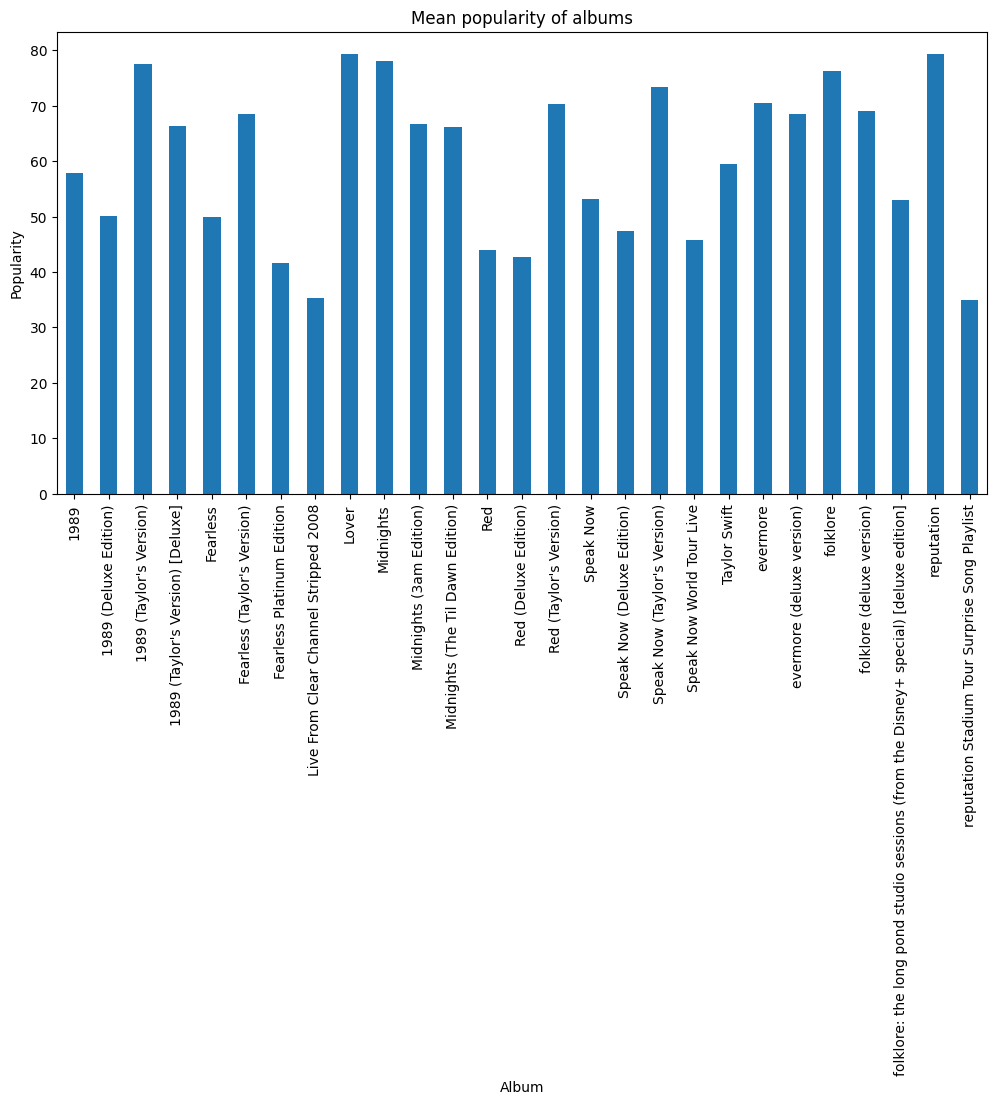

In [ ]:
grouped_songs = songs.groupby('album')['popularity'].mean()
grouped_songs.plot(kind='bar')
plt.xlabel('Album')
plt.ylabel('Popularity')
plt.title('Mean popularity of albums')
plt.show()

### Checking datatypes

In [ ]:
songs.dtypes

name                 object
album                object
release_date          int64
track_number          int64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
duration_ms           int64
performed_live         bool
taylors_version        bool
deluxe_album           bool
dtype: object

### Feature Scaling

Popularity scaling

<Axes: >

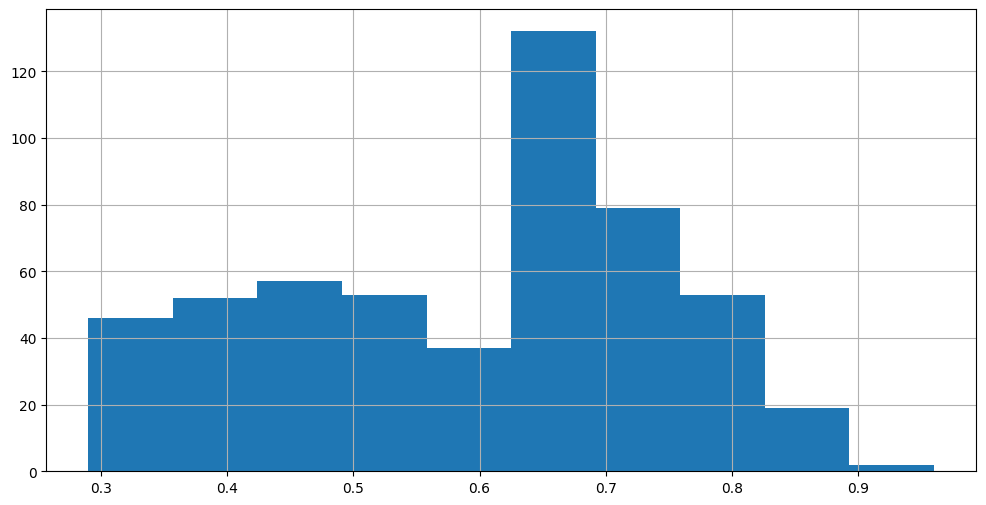

In [135]:

# Popularity [0,1]
songs_scaled = songs
songs_scaled['popularity'] = songs_scaled['popularity']/100
songs_scaled['popularity'].hist()


Duration Scaling

In [136]:
# duration ms to s
songs_scaled['duration_ms'] = round(songs['duration_ms']/1000)
songs_scaled['duration_ms'] = [int(t) for t in songs_scaled['duration_ms']]
songs_scaled = songs_scaled.rename(columns = {'duration_ms': 'duration'})

songs_scaled['duration'].head()

0    213.0
1    232.0
2    231.0
3    236.0
4    193.0
Name: duration, dtype: float64

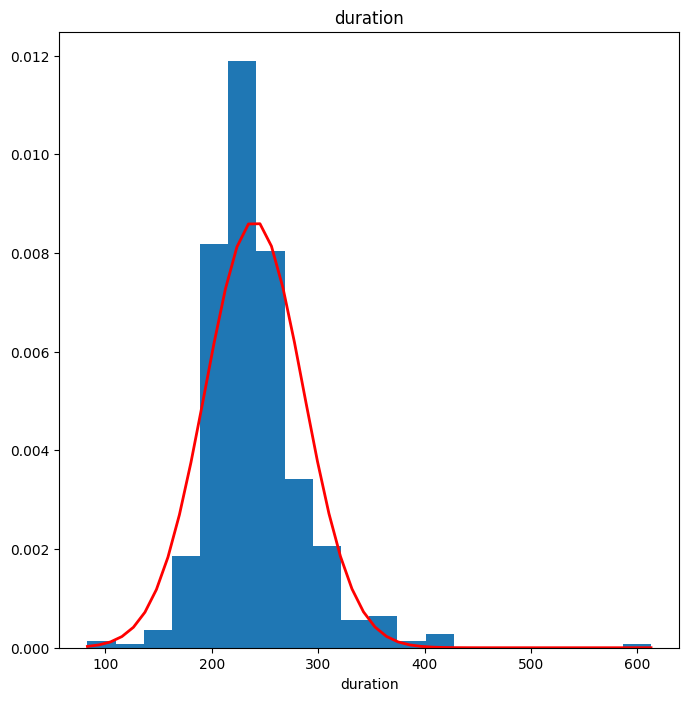

In [150]:
sigma=  songs_scaled.duration.std()
mu=  songs_scaled.duration.mean()
fig, ax = plt.subplots(figsize=(8,8))
count, bins, ignored = plt.hist(songs_scaled.duration, 20, density=True)
dbins = np.linspace(bins[0], bins[-1])
plt.title("duration")
ax.set_xlabel("duration")
plt.plot(dbins, 1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (dbins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r');

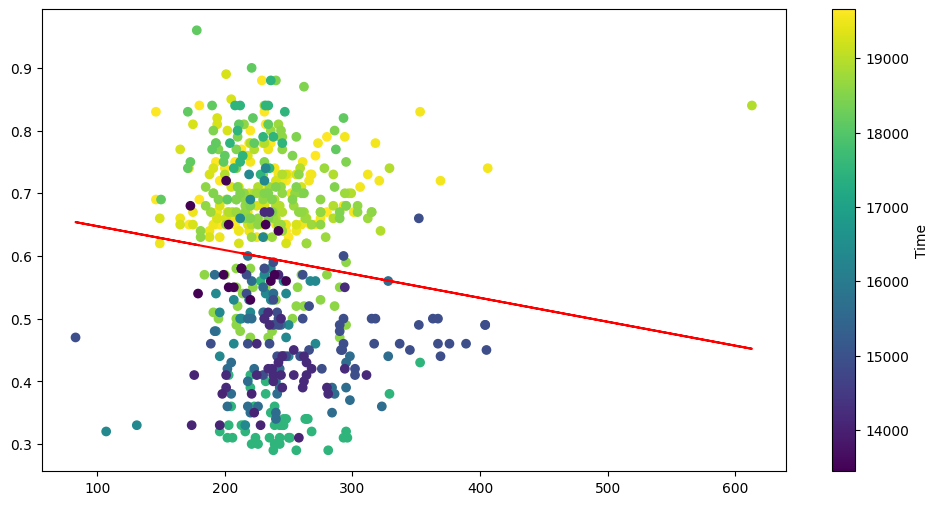

-0.000381230811176935 0.6855920582510361


In [160]:

# popularity vs duration
plt.scatter(songs_scaled['duration'], songs_scaled['popularity'], c = songs_scaled['release_date'])
plt.colorbar(label='Time')

# Linear regression line
x = songs_scaled['duration']
y = songs_scaled['popularity']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')

plt.show()
print(m, b)

# NO té sentit categoritzar 'duration': per exemple 'short', 'average', 'long'




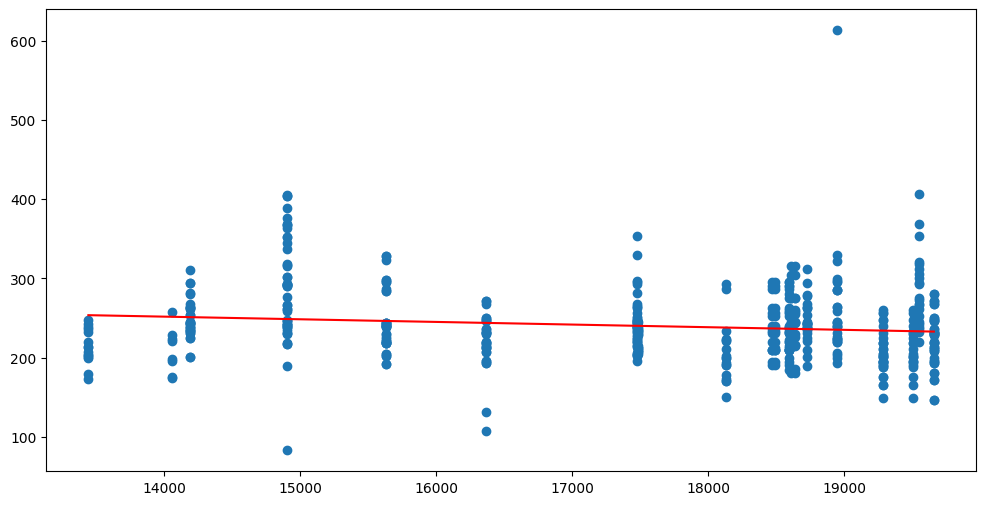

-0.003334781634390085 298.33091809684856


In [163]:
# Scatter plot
plt.scatter(songs_scaled['release_date'], songs_scaled['duration'])

# Linear regression line
x = songs_scaled['release_date']
y = songs_scaled['duration']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')

plt.show()
print(m, b)


We see that the duration of songs remains constant over time. We can't see a clear correlation between the song being 'short', 'medium' or 'long', so we might prefer to keep duration as a numeric variable instead of a categorical one.

Dnceability, tempo, energy...

<Axes: >

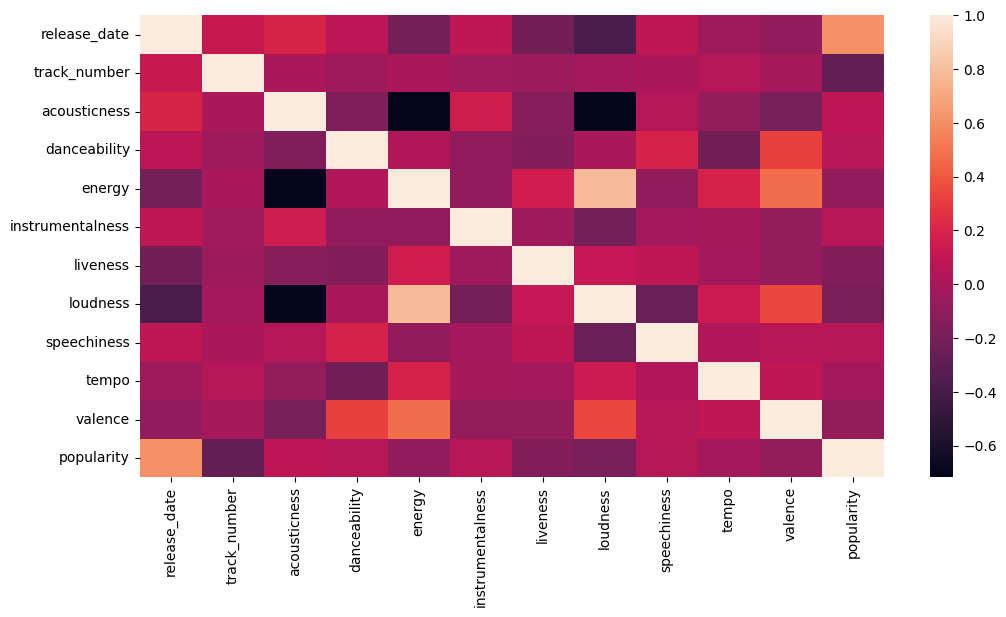

In [171]:
import seaborn as sns

idx = [i for i in range(2,14)] # numeric data
corr = songs_scaled.iloc[:, idx].corr()
#corr.style.background_gradient(cmap='coolwarm')
sns.heatmap(corr)

Problemes: veiem com acousticness, danceability, enrgy i loudness estan totes relacionades entre elles. A més a més, relase_date i popularity fortament correlades (ja ho sabíem).